<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0.1)


In [2]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor


In [3]:
# Познакомимся с данными
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
# Отсортируем по времени
data.sort_index(ascending=True, inplace=True)
print(data.index.is_monotonic)
# Проведем ресемблинг
data = data.resample('1H').sum()
display(data.head())
# Проверим на пропуски 
print(f"Количество пропусков {data.isnull().sum()}")

True


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Количество пропусков num_orders    0
dtype: int64


## Анализ

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


None

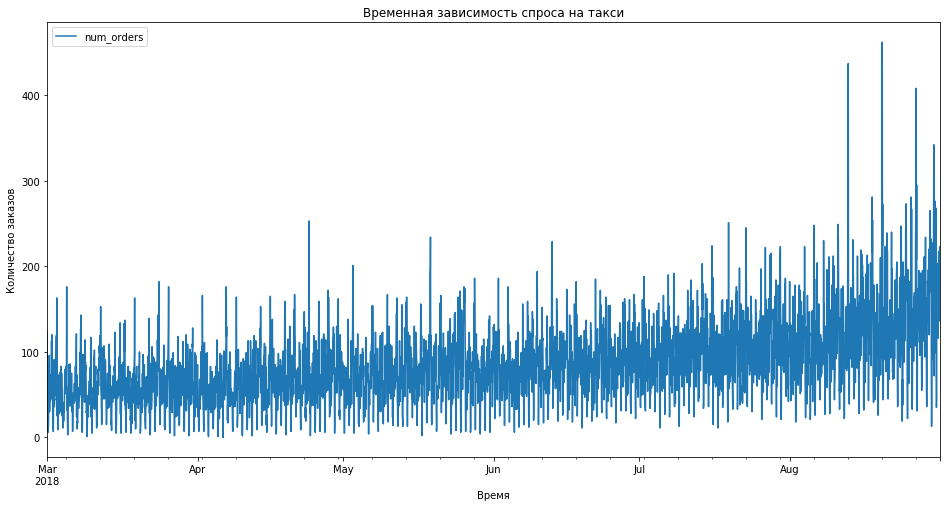

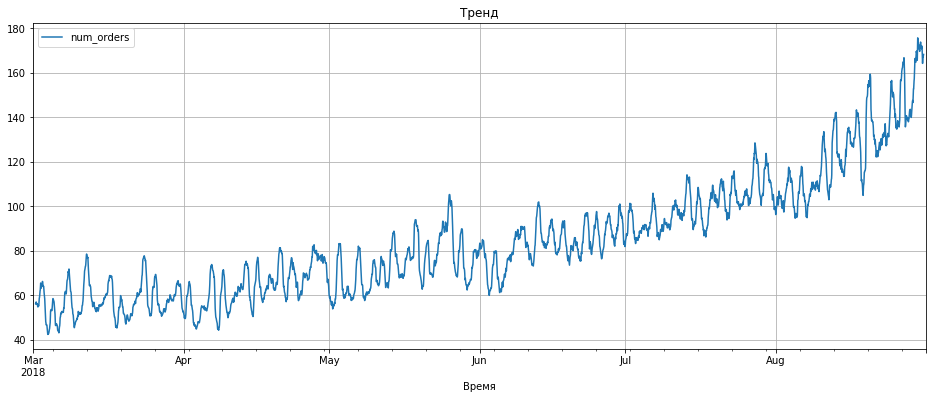

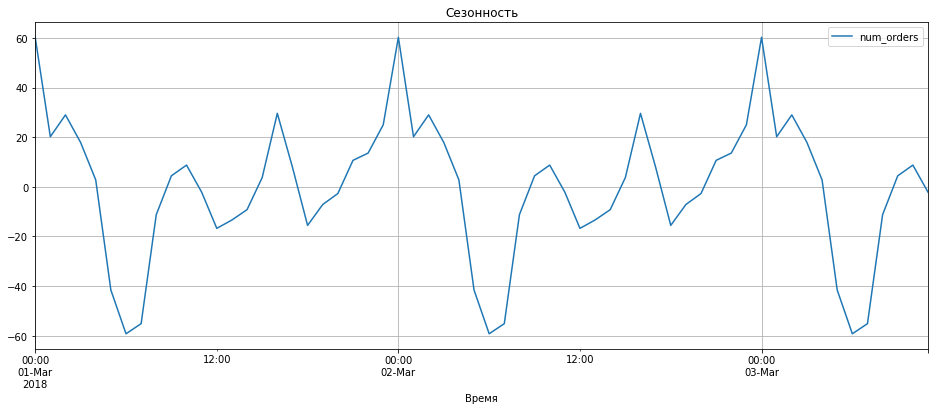

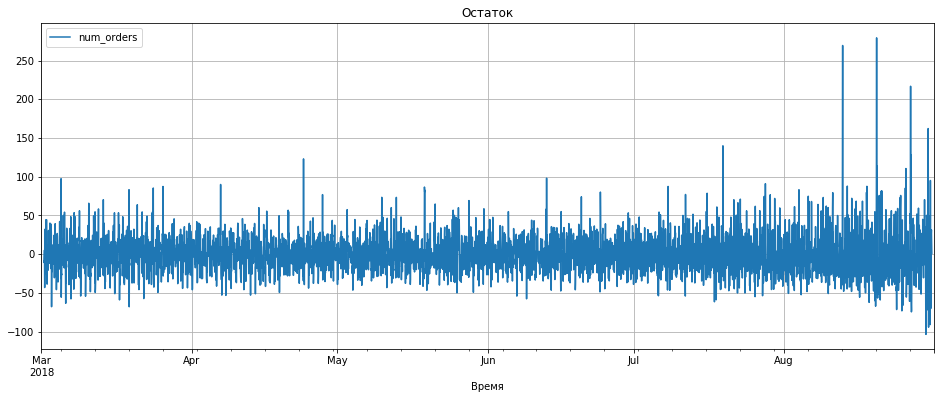

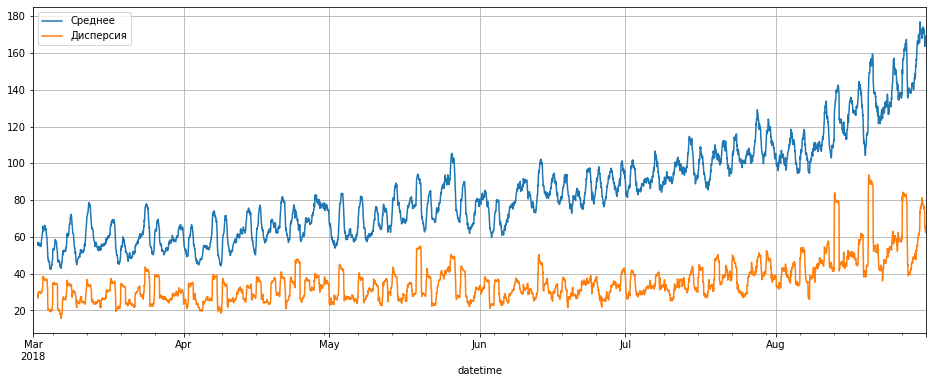

In [4]:
# Напишем функцию для визуализации основных элементов
def get_plots(data):
    # Визуализируем ряд
    data.plot(figsize=(16,8))
    plt.title("")
    plt.xlabel('Время')
    plt.ylabel('Количество заказов')
    plt.title('Временная зависимость спроса на такси')
    # Разложим ряд на состовляющие
    decomposed = seasonal_decompose(data)
    decomposed.trend.plot(title='Тренд', figsize=(16,6))
    plt.xlabel('Время')
    plt.grid()
    decomposed.seasonal.iloc[:60].plot(title='Сезонность', figsize=(16,6))
    plt.xlabel('Время')
    plt.grid()
    decomposed.resid.plot(title='Остаток', figsize=(16,6))
    plt.xlabel('Время')
    plt.grid()
    # Посмотри на среднее и дисперсию
    plt.figure(figsize=(16, 6))
    data['num_orders'].rolling(24).mean().plot(label="Среднее")
    data['num_orders'].rolling(24).std().plot(label="Дисперсия")
    plt.legend()
    plt.grid()
    
    
display(data.info())
get_plots(data)

**Выводы:**

- Датасет имеет данные за полгода, начиная с марта 2018

- Исходный ряд нестационарен: и среднее значение, и дисперсия растут со временем. 

- Зависимость имеет восходящий тренд 

- Временной ряд имеет сезонность с периодом в 1 день


## Обучение

In [6]:
# Напишем функцию для создания новых признаков
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new[f'lag_{lag}'] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

Создадим новые признаки. Так как имеется дневная сезонность, то установим max_lag=24, а rolling_mean_size=16

In [7]:
# Создадим новые признаки
processed_data = make_features(data, 24, 16)
display(processed_data.head(5))
# Разобьем данные на тренировочную и тестовую выборки
train, test = train_test_split(processed_data, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']
features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Обучим разные модели с различными гипермараметрами

In [8]:
# Зададим разбиение для кросс-валидации для случая временного ряда
tscv = TimeSeriesSplit(n_splits=3)

In [9]:
# Подберем параметры для дерева решений
DTR = DecisionTreeRegressor(random_state=12345)
params = {'max_depth':list(range(1,32,5))}
DTR = GridSearchCV(DTR, params, scoring='neg_root_mean_squared_error', cv=tscv)
DTR.fit(features_train, target_train)
DTR.best_params_

{'max_depth': 6}

In [10]:
# Подберем параметры для случайного леса
RFR = RandomForestRegressor(random_state=12345)
params = {'max_depth':list(range(1,32,10)), 
         'n_estimators': list(range(1,201,30))}
RFR = GridSearchCV(RFR, params, scoring='neg_root_mean_squared_error', cv=tscv, verbose=48, n_jobs=-1)
RFR.fit(features_train, target_train)
RFR.best_params_

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV 1/3; 1/28] START max_depth=1, n_estimators=1................................
[CV 1/3; 1/28] END max_depth=1, n_estimators=1;, score=-31.241 total time=   0.0s
[CV 2/3; 1/28] START max_depth=1, n_estimators=1................................
[CV 2/3; 1/28] END max_depth=1, n_estimators=1;, score=-33.156 total time=   0.0s
[CV 3/3; 1/28] START max_depth=1, n_estimators=1................................
[CV 3/3; 1/28] END max_depth=1, n_estimators=1;, score=-44.515 total time=   0.0s
[CV 1/3; 2/28] START max_depth=1, n_estimators=31...............................
[CV 1/3; 2/28] END max_depth=1, n_estimators=31;, score=-30.470 total time=   0.1s
[CV 2/3; 2/28] START max_depth=1, n_estimators=31...............................
[CV 2/3; 2/28] END max_depth=1, n_estimators=31;, score=-33.539 total time=   0.1s
[CV 3/3; 2/28] START max_depth=1, n_estimators=31...............................
[CV 3/3; 2/28] END max_depth=1, n_estimat

[CV 2/3; 17/28] END max_depth=21, n_estimators=61;, score=-25.321 total time=   1.4s
[CV 3/3; 17/28] START max_depth=21, n_estimators=61.............................
[CV 3/3; 17/28] END max_depth=21, n_estimators=61;, score=-33.166 total time=   2.2s
[CV 1/3; 18/28] START max_depth=21, n_estimators=91.............................
[CV 1/3; 18/28] END max_depth=21, n_estimators=91;, score=-24.794 total time=   1.0s
[CV 2/3; 18/28] START max_depth=21, n_estimators=91.............................
[CV 2/3; 18/28] END max_depth=21, n_estimators=91;, score=-25.087 total time=   2.2s
[CV 3/3; 18/28] START max_depth=21, n_estimators=91.............................
[CV 3/3; 18/28] END max_depth=21, n_estimators=91;, score=-33.123 total time=   3.4s
[CV 1/3; 19/28] START max_depth=21, n_estimators=121............................
[CV 1/3; 19/28] END max_depth=21, n_estimators=121;, score=-24.784 total time=   1.6s
[CV 2/3; 19/28] START max_depth=21, n_estimators=121............................
[CV

{'max_depth': 31, 'n_estimators': 181}

In [11]:
# Подберем параметры для градиентного бустинга
LGBM = LGBMRegressor(random_state=12345)
params = {'max_depth':list(range(1,32,15)), 
         'n_estimators': list(range(1,201,30))}
LGBM = GridSearchCV(LGBM, params, scoring='neg_root_mean_squared_error', cv=tscv, verbose=48, n_jobs=-1)
LGBM.fit(features_train, target_train)
LGBM.best_params_

Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV 1/3; 1/21] START max_depth=1, n_estimators=1................................
[CV 1/3; 1/21] END max_depth=1, n_estimators=1;, score=-34.883 total time=   0.1s
[CV 2/3; 1/21] START max_depth=1, n_estimators=1................................
[CV 2/3; 1/21] END max_depth=1, n_estimators=1;, score=-38.444 total time=   0.0s
[CV 3/3; 1/21] START max_depth=1, n_estimators=1................................
[CV 3/3; 1/21] END max_depth=1, n_estimators=1;, score=-52.220 total time=   0.1s
[CV 1/3; 2/21] START max_depth=1, n_estimators=31...............................
[CV 1/3; 2/21] END max_depth=1, n_estimators=31;, score=-27.427 total time=   0.1s
[CV 2/3; 2/21] START max_depth=1, n_estimators=31...............................
[CV 2/3; 2/21] END max_depth=1, n_estimators=31;, score=-29.430 total time=   0.1s
[CV 3/3; 2/21] START max_depth=1, n_estimators=31...............................
[CV 3/3; 2/21] END max_depth=1, n_estimat

[CV 2/3; 17/21] END max_depth=31, n_estimators=61;, score=-25.005 total time=   0.8s
[CV 3/3; 17/21] START max_depth=31, n_estimators=61.............................
[CV 3/3; 17/21] END max_depth=31, n_estimators=61;, score=-32.497 total time=   1.0s
[CV 1/3; 18/21] START max_depth=31, n_estimators=91.............................
[CV 1/3; 18/21] END max_depth=31, n_estimators=91;, score=-24.042 total time=   1.1s
[CV 2/3; 18/21] START max_depth=31, n_estimators=91.............................
[CV 2/3; 18/21] END max_depth=31, n_estimators=91;, score=-24.966 total time=   1.2s
[CV 3/3; 18/21] START max_depth=31, n_estimators=91.............................
[CV 3/3; 18/21] END max_depth=31, n_estimators=91;, score=-32.175 total time=   1.3s
[CV 1/3; 19/21] START max_depth=31, n_estimators=121............................
[CV 1/3; 19/21] END max_depth=31, n_estimators=121;, score=-24.151 total time=   1.5s
[CV 2/3; 19/21] START max_depth=31, n_estimators=121............................
[CV

{'max_depth': 31, 'n_estimators': 91}

## Тестирование

In [12]:
# Создадим различные модели с оптимальными параметрами, полученными в предыдущем пункте
LR = LinearRegression()
DTR = DecisionTreeRegressor(random_state=12345, max_depth=DTR.best_params_['max_depth'])
RFR = RandomForestRegressor(random_state=12345, max_depth=RFR.best_params_['max_depth'], n_estimators=RFR.best_params_['n_estimators'])
LGBM = LGBMRegressor(random_state=12345, max_depth=LGBM.best_params_['max_depth'], n_estimators=LGBM.best_params_['n_estimators'])
DR = DummyRegressor(strategy='mean')
# Создадим списки, содержащие значения метрики
train_rmse = []
test_rmse = []
predictions = []
models = [LR, DTR, RFR, LGBM, DR]
# Обучим модели и оценим качество предсказаний
for model in models:
    model.fit(features_train, target_train)
    pred_test = model.predict(features_test)
    pred_train = model.predict(features_train)
    predictions.append(pred_test)
    train_rmse.append(mean_squared_error(target_train, pred_train, squared=False))
    test_rmse.append(mean_squared_error(target_test, pred_test, squared=False))
    
# Создадим датафрейм с результатами
df = pd.DataFrame(
    [train_rmse,test_rmse], 
    columns=['Линейная регрессия', "Дерево решений", "Случайный лес", "Градиентный бустинг", 'Dummy модель'], 
    index=['RMSE на тренировочной выборке','RMSE на тестовой выборке' ])
display(df.head())

,Линейная регрессия,Дерево решений,Случайный лес,Градиентный бустинг,Dummy модель
RMSE на тренировочной выборке,25.818602,23.518286,8.621292,12.974374,38.682894
RMSE на тестовой выборке,45.529337,59.160287,42.760312,42.457885,84.649938


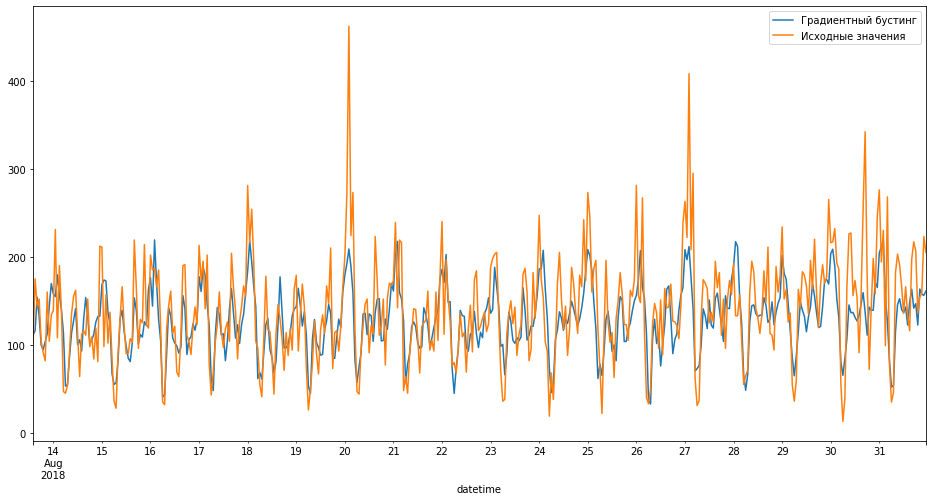

In [14]:
# Графически сравним предсказания с исходным рядом
plt.figure(figsize=(16,8))
pd.Series(predictions[3], index=target_test.index).plot(label='Градиентный бустинг')
target_test.plot(label='Исходные значения')
plt.legend()

## Выводы

В рамках данного проекта были обучены несколько моделей и получены следующие результаты:

- Зависимость спроса на такси имела возрастающий тренд и однодневную сезонность.
- Исходный временной ряд был нестационарным, имел возрастающее среднее. 
- Были обучены 4 модели и сравнены с dummy моделью, которая выдавала значение RMSE=58,9. Все модели были лучше модели-болванки.
- Каждая из моделей переобучилась на тренировочной выборке. Наибольшее отклонение в значениях метрики на тестовой и тренировочной выборках были замечены у случайного леса и градиентного бустинга. 
- Дерево решений не смогло побить требуемое значение метрики
- Лучше всех на тестовой выборке себя проявили модели случайного леса бустинга с близкими значениями метрики равной 43. По графику видно, что градиентный бустинг зачастую предсказывал значения ниже реальных, особенно это видно для выбросов с большим количество заказов

С точки зрения качетсва побеждает градиентный бустинг. Однако, если важна скорость обучения и степень переобучения, а точностью предсказаний можно немного пренебречь, то стоит выбрать модель линейной регрессии.